In [21]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize_scalar


%matplotlib inline

In [74]:
def make_np_array(x):
    if type(x) != np.ndarray and type(x) != list and type(x) != tuple:
        return np.array([x])
    else:
        return np.array(x)

In [182]:
def draw_plots(values, times, names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    
    for name_, values_ in zip(names, values):
        axs[0].plot(values_, label=name_)
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    
    for name_, times_ in zip(names, times):
        axs[1].plot(times_, label=name_)
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Time, s')
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].legend()
    axs[1].legend()
    
    plt.show()

As the simplest examples of the non-linear equations we decided to consider polymonials.

**Generation:** Polynomials are randomly generated. We consider a canonical polynomial:

$g(x) = a_qx^q + a_{q - 1}x^{q - 1} + \ldots + a_0$

$a = \begin{pmatrix} a_0 \\ \vdots \\ a_q \end{pmatrix}$, where $\forall i$ smallest_coefficient < $a_i$ < largest_coefficient.

The gradient is:
$g'(x) = a_q \cdot q \cdot x^{q - 1} + a_{q - 1} \cdot (q - 1) \cdot x^{q - 2} + \ldots + a_1$

In [199]:
class PolynomialData():
    def __init__(self, degree,
                 smallest_coefficient=-100,
                 largest_coefficient=100,
                 a = None):
        self._degree = degree
        if a is None:
            self._a = smallest_coefficient + (np.random.rand(self._degree + 1) * (largest_coefficient - smallest_coefficient))
        else:
            self._a = np.array(a[::-1])
            
    def forward(self, x):
        # stacked x is a matrix, [1, ..., x^(q - 1), x^q]
        stacked_x = np.array([x ** i for i in range(self._degree + 1)])
        
        return stacked_x.T @ self._a
        
    def grad(self, x):
        stacked_x = np.array([x ** i for i in range(self._degree)])

        return stacked_x.T @ (self._a[1:] * np.arange(1, self._degree + 1))
    
    def hess(self, x):
        stacked_x = np.array([x ** i for i in range(self._degree - 1)])
        
        return stacked_x.T @ (self._a[2:] * np.arange(2, self._degree + 1) * np.arange(1, self._degree))
    
    def __str__(self):
        return '+'.join([f'{self._a[i]}x^{i}' for i in range(0, self._degree + 1)][::-1])
    
    def grad_str(self):
        return '+'.join([f'{self._a[i]} * {i} * x^{i - 1}' for i in range(1, self._degree + 1)][::-1])
    
    def hess_str(self):
        return '+'.join([f'{self._a[i]} * {i} * {i - 1} * x^{i - 2}' for i in range(2, self._degree + 1)][::-1])

In [200]:
p = PolynomialData(2, a=[2, 3, 1])

As proposed in the project description we transform the data as follows to get the convex minimization task:

$f(x) = \sum\limits_{i = 0}^n g_i(x)^p \to \min$, $p \geq 1$

Class PolynomialOptimData transforms the PolynomialData this way.

In [185]:
class PolynomialOptimData():
    def __init__(self, g, p = 2):
        self._g = g
        self._p = p
    
    def forward(self, x):
        g = self._g.forward(x)
        return (g ** self._p).sum()
        
    def grad(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x)
        return make_np_array(self._p * (g ** (self._p - 1)) @ grad_g)
    
    def hess(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x)
        hess_g = self._g.hess(x)
        return make_np_array(self._p * (self._p - 1) * (g ** (self._p - 2)) @ grad_g + self._p * (g ** (self._p - 1)) @ hess_g)

# Newton's Algorithms

Solving g(x) = 0, $x_k = x_{k - 1} - \frac{g(x)}{g'(x)}$

In [186]:
class NewtonSolvingAlgorithm():
    def __init__(self):
        pass
    
    def solve(self, equation, x0, iterations=10):
        x = x0
        x_history = [x]
        values_history = [np.linalg.norm(equation.forward(x), ord=2)]
        times_history = [0]
        
        start = time()
        for i in range(iterations):
            x = x - equation.forward(x) / equation.grad(x)
            
            values_history.append(np.linalg.norm(equation.forward(x), ord=2))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

Optimizing f(x) $\to$ $\min$, $x_k = x_{k - 1} - \frac{f'(x)}{f''(x)}$

In [187]:
class NewtonOptimizationAlgorithm():
    def __init__(self):
        pass
    
    def optimize(self, function, x0, iterations=10):
        x = x0
        
        x_history = [x]
        values_history = [function.forward(x)]
        times_history = [0]
        
        start = time()
        for i in range(iterations):
            x = x - function.grad(x) / function.hess(x)
            
            values_history.append(function.forward(x))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

# Conjugated Gradients

In [180]:
class ConjugateGradient():
    def __init__(self):
        pass
    
    def optimize(self, regression, iterations=10, method='fletcher-reeves', x0=None, default_step=0.01,
                line_search_iter=50, line_search_tolerance=10):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
        
        # conjugate direction
        d = -regression.grad(x)
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        for i in tqdm(range(iterations)):
            # line search alpha
            #alpha = line_search(regression.forward, regression.grad, x, d, maxiter=100)[0]
            
            alpha = minimize_scalar(lambda l: regression.forward(x + l * d),
                                       bounds=(0, default_step), method='Golden',
                                       options={'maxiter':line_search_iter,
                                                'xtol': default_step / line_search_tolerance})
            alpha = alpha['x']
            if alpha == 0:
                print(f'Line search did not converge on iteration {i}, using default step')
                alpha = default_step / (i + 1)
                #return x_history, values_history, times_history
            
            # update x_k + 1
            x = x + alpha * d
            x_history.append(x)
            values_history.append(regression.forward(x))
            
            # compute g_k + 1
            g = regression.grad(x)
            grads_history.append(g)
            
            # update d_k + 1
            if method == 'fletcher-reeves':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = (g.T @ g) / (grads_history[-2].T @ grads_history[-2])
            elif method == 'polak-ribiere':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = ((g - grads_history[-2]).T @ g) / (grads_history[-2].T @ grads_history[-2])
            else:
                raise Exception(f'Unknown method: {method}')
            d = -g + beta * d
            
            # update times history
            times_history.append(time() - start)
        print(f'Conjugate gradient converged on iteration {i}')
        return x_history, values_history, times_history

In [283]:
g = PolynomialData(100000)
f = PolynomialOptimData(g, p = 2)

In [284]:
ns = NewtonSolvingAlgorithm()
no = NewtonOptimizationAlgorithm()
cg = ConjugateGradient()

In [285]:
x_history_ns, values_history_ns, times_history_ns = ns.solve(g, x0=x0)
x_history_no, values_history_no, times_history_no = no.optimize(f, x0=x0)
x_history_fr, values_history_fr, times_history_fr = cg.optimize(f, x0=x0, default_step=1e-2, method='fletcher-reeves')
x_history_pr, values_history_pr, times_history_pr = cg.optimize(f, x0=x0, default_step=1e-2, method='polak-ribiere')

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in power
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in matmul


Line search did not converge on iteration 5, using default step

Conjugate gradient converged on iteration 9



Conjugate gradient converged on iteration 9


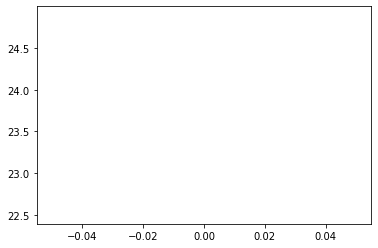

In [276]:
plt.plot(values_history_ns)

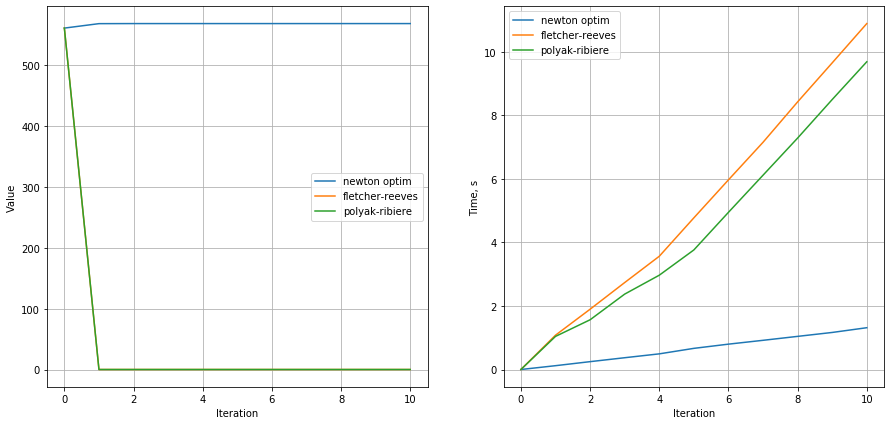

In [282]:
draw_plots([values_history_no, values_history_fr, values_history_pr],
          [times_history_no, times_history_fr, times_history_pr],
          ['newton optim', 'fletcher-reeves', 'polyak-ribiere'])

In [281]:
x_history_ns

[array([0.55720978]),
 array([-1.69332247]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan])]

In [280]:
values_history_ns

[23.69530510576867, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

# Generated PowerFlow

In [286]:
class 

In [ ]:
GeneratedPowerFlowData()